In [2]:
pip install tensorflow keras numpy pandas matplotlib opencv-python scikit-learn

In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


CUDA Available: True
CUDA Version: 12.4
GPU Name: Tesla T4


In [3]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [4]:
# Define paths
zip_path = "archive.zip"
extract_path = "fer2013_data/"

# Extract if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extraction complete")

train_dir = "fer2013_data/train/"
test_dir = "fer2013_data/test/"

print("Train categories:", os.listdir(train_dir))
print("Test categories:", os.listdir(test_dir))

Extraction complete
Train categories: ['happy', 'angry', 'neutral', 'disgust', 'sad', 'surprise', 'fear']
Test categories: ['happy', 'angry', 'neutral', 'disgust', 'sad', 'surprise', 'fear']


In [5]:
import torch
RANDOM_STATE = 42
LEARNING_RATE = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
NUM_CLASSES = 7
torch.manual_seed(RANDOM_STATE)

In [6]:
# Data augmentation for better accuracy
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load images from directory
train_generator = datagen.flow_from_directory(
    "fer2013_data/train/",
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Change from 'grayscale' to 'rgb'
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    "fer2013_data/test/",
    target_size=(48, 48),
    batch_size=64,
    color_mode="rgb",  # Change from 'grayscale' to 'rgb'
    class_mode="categorical"
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#----------------------------------

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

In [19]:
RANDOM_STATE = 42
LEARNING_RATE = 0.0001
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7  # 7 emotion classes

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),  # ensure images are grayscale
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [10]:
# Define paths for training and testing data directories
train_dir = "fer2013_data/train"  # contains subfolders for each emotion
test_dir  = "fer2013_data/test"   # contains subfolders for each emotion

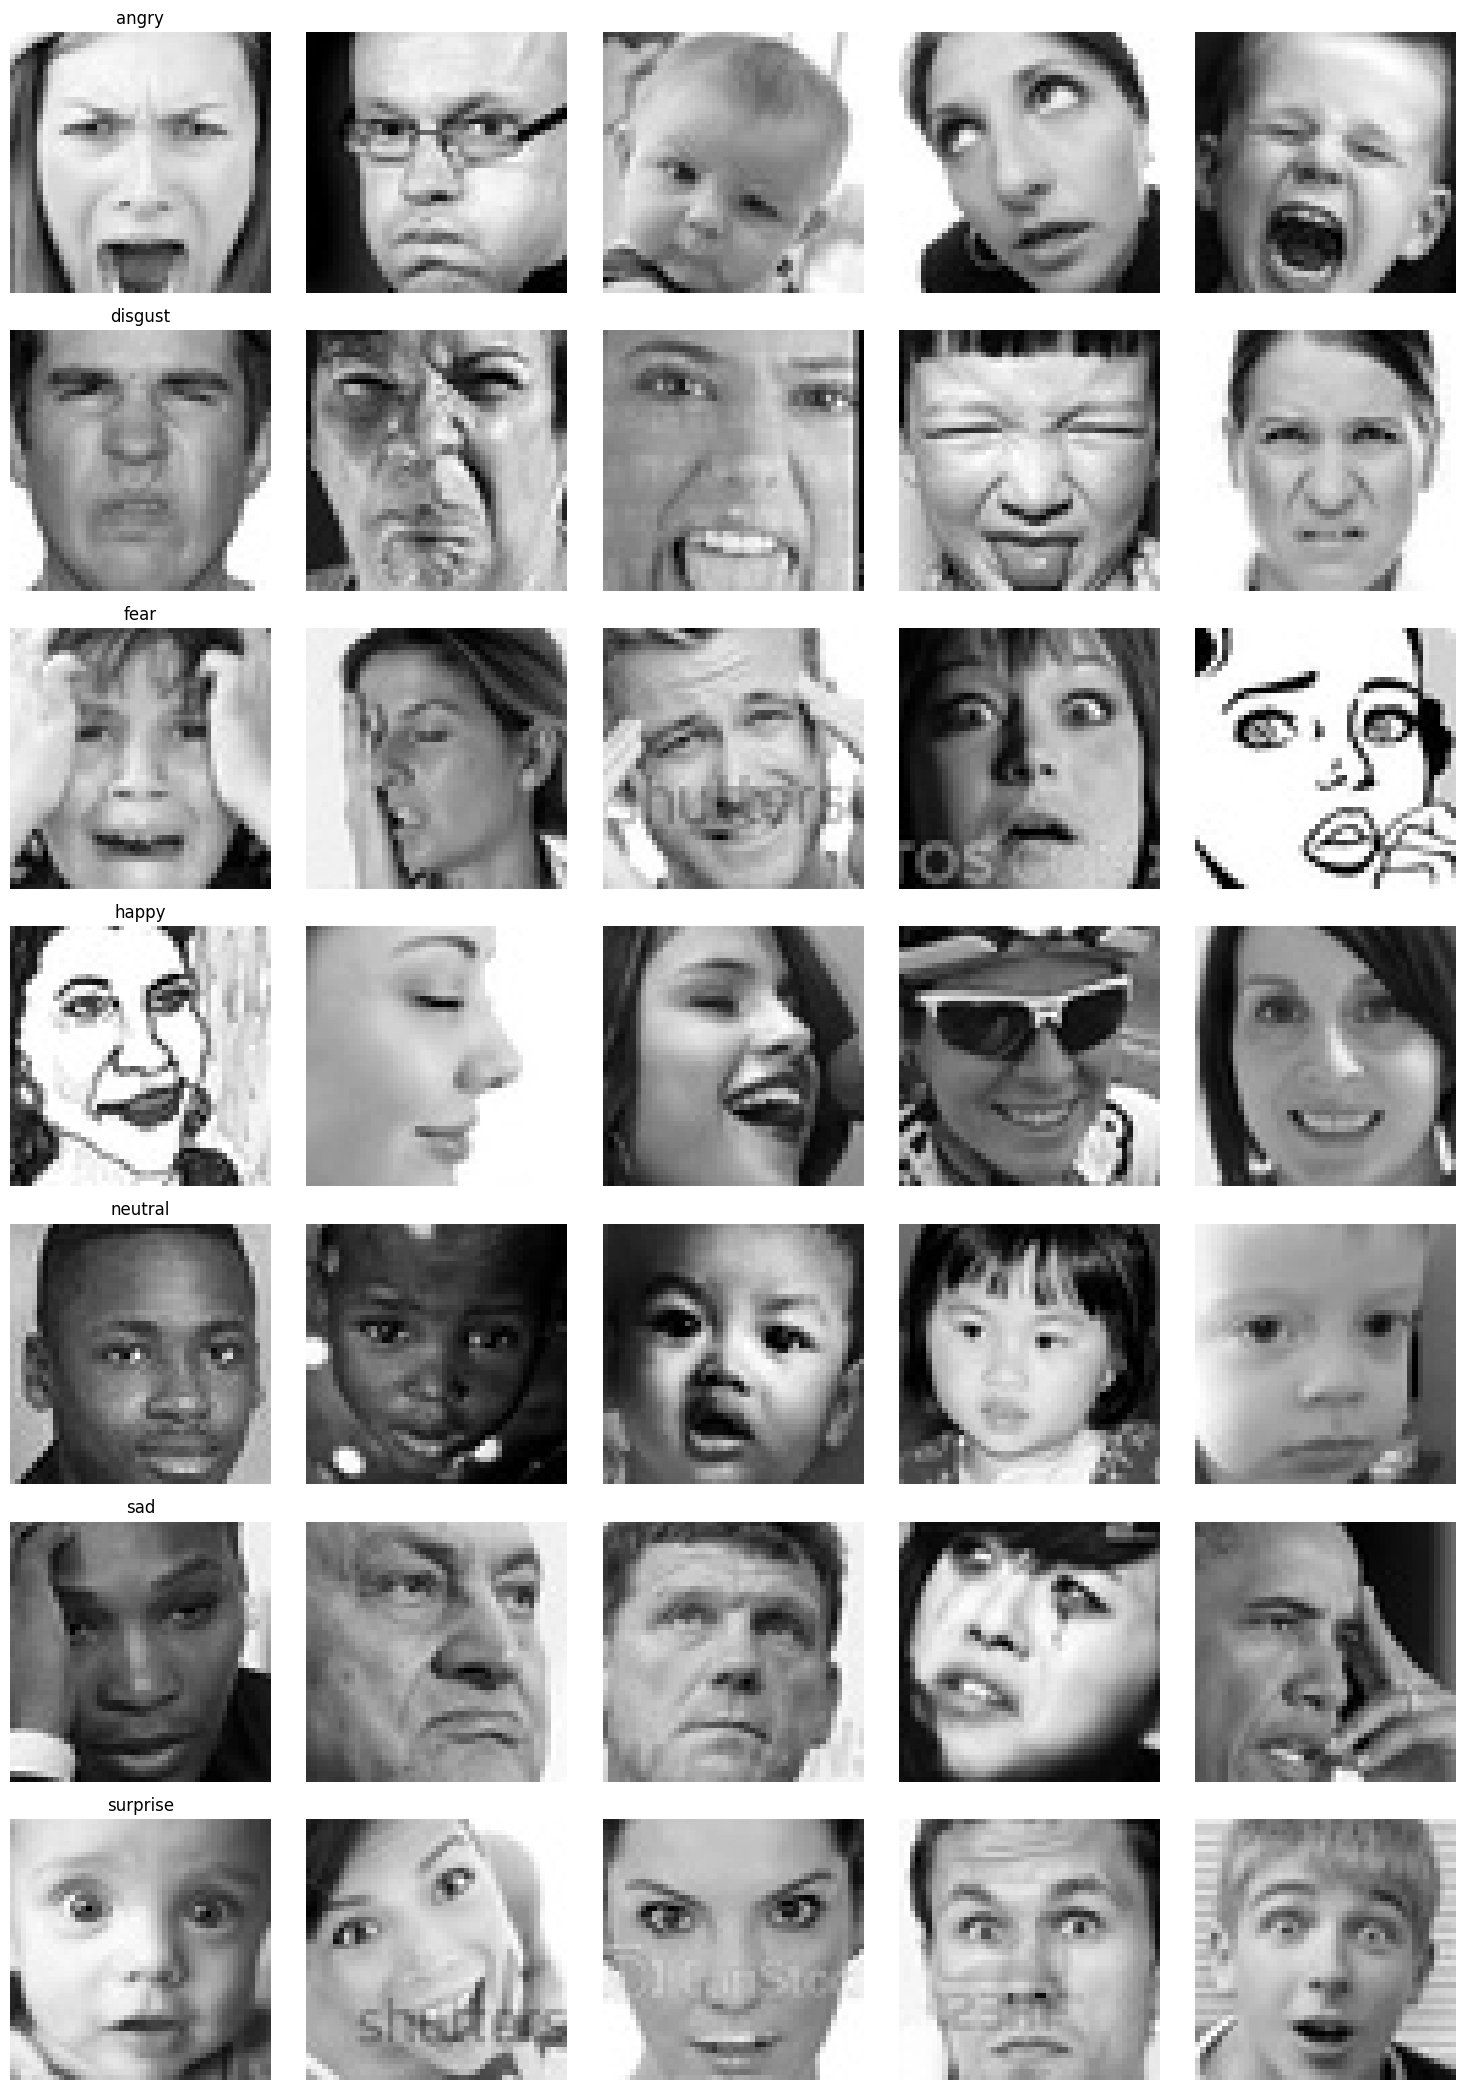

In [23]:
# Get emotion categories (subfolder names)
categories = sorted(os.listdir(train_dir))

# Number of images per category to display
num_images = 5

# Set up plot with multiple rows
fig, axes = plt.subplots(len(categories), num_images, figsize=(num_images * 3, len(categories) * 3))

# Loop through categories and select images
for row, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_names = os.listdir(category_path)[:num_images]  # Select first 5 images

    for col, image_name in enumerate(image_names):
        image_path = os.path.join(category_path, image_name)
        img = Image.open(image_path).convert("L")  # Ensure RGB mode

        axes[row, col].imshow(img,cmap="gray")
        axes[row, col].set_title(category if col == 0 else "")  # Only set title for first column
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Load datasets using ImageFolder (folder names define class labels)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
class CNN(nn.Module):
    def __init__(self, channels, num_classes):
        super(CNN, self).__init__()
        # Convolutional Blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=5, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.fc_layers(x)
        return x

In [14]:
# Instantiate the model (running on CPU)
model = CNN(channels=1, num_classes=NUM_CLASSES)
model.to("cuda")
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             832
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          51,264
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]         204,928
      BatchNorm2d-10          [-1, 128, 12, 12]             256
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 512, 6, 6]       1,638,912
      BatchNorm2d-14            [-1, 51

In [15]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()  # Use class weights if needed for imbalanced classes

In [16]:
# Training loop: one epoch
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return running_loss / len(dataloader), 100.0 * correct / total

In [17]:
# Evaluation loop
def evaluate(model, dataloader, loss_fn):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100.0 * correct / total

In [24]:
best_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
    test_acc = evaluate(model, test_dataloader, loss_fn)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

Epoch [1/100]: Train Loss: 1.1797 | Train Acc: 55.66% | Test Acc: 56.77%
Epoch [2/100]: Train Loss: 1.1487 | Train Acc: 57.03% | Test Acc: 57.22%
Epoch [3/100]: Train Loss: 1.1173 | Train Acc: 57.77% | Test Acc: 57.90%
Epoch [4/100]: Train Loss: 1.0963 | Train Acc: 58.54% | Test Acc: 58.62%
Epoch [5/100]: Train Loss: 1.0714 | Train Acc: 59.74% | Test Acc: 60.35%
Epoch [6/100]: Train Loss: 1.0455 | Train Acc: 60.70% | Test Acc: 60.88%
Epoch [7/100]: Train Loss: 1.0246 | Train Acc: 61.47% | Test Acc: 61.27%
Epoch [8/100]: Train Loss: 1.0014 | Train Acc: 62.48% | Test Acc: 60.88%
Epoch [9/100]: Train Loss: 0.9825 | Train Acc: 62.95% | Test Acc: 61.15%
Epoch [10/100]: Train Loss: 0.9614 | Train Acc: 63.84% | Test Acc: 60.85%
Epoch [11/100]: Train Loss: 0.9447 | Train Acc: 64.74% | Test Acc: 59.22%
Epoch [12/100]: Train Loss: 0.9333 | Train Acc: 65.05% | Test Acc: 62.43%
Epoch [13/100]: Train Loss: 0.9094 | Train Acc: 66.03% | Test Acc: 61.09%
Epoch [14/100]: Train Loss: 0.8895 | Train Acc:

In [27]:
import torch
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

y_true = []
y_pred = []

# Ensure model is on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs  = inputs.to(device)
        labels  = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Move tensors to CPU before converting to numpy
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print("Test Accuracy:", accuracy_score(y_true, y_pred))


<ipython-input-27-c343fbd19865>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       958
           1       0.71      0.60      0.65       111
           2       0.59      0.45      0.51      1024
           3       0.85      0.85      0.85      1774
           4       0.60      0.65      0.63      1233
           5       0.50      0.59      0.54      1247
           6       0.77      0.81      0.79       831

    accuracy                           0.66      7178
   macro avg       0.66      0.64      0.65      7178
weighted avg       0.67      0.66      0.66      7178

Macro F1 Score: 0.6486451630411091
Test Accuracy: 0.6635553078852048


In [29]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


<ipython-input-29-568ab1fcc23f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2